In [1]:
# !python -m pip install keras
# !python -m pip install tensorflow

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn import preprocessing
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

import pybithumb




### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=10)
        plt.xlabel('Index', fontsize=8)
        plt.ylabel('Target Value', fontsize=8)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=1)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(15,5))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(15,5))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(15,8))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score

DF shape:  (2553, 5)


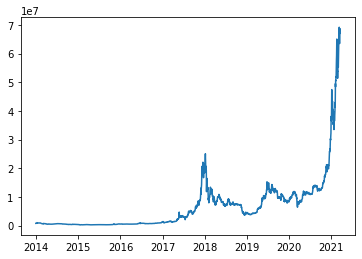

In [3]:
# Data
detail = pybithumb.get_market_detail('BTC') # 
df = pybithumb.get_ohlcv('BTC')
df = df[:-1]
# df = df.loc[df.index >= '2017-01-01']
print('DF shape: ', df.shape)
# target graph
df = df[['close']]
plt.plot(df['close'])
plt.show()

In [4]:
pybithumb.get_ohlcv('BTC')

,open,high,low,close,volume
time,,,,,
2013-12-27 00:00:00,737000.0,755000.0,737000.0,755000.0,3.780000
2013-12-28 00:00:00,750000.0,750000.0,750000.0,750000.0,12.000000
2013-12-29 00:00:00,750000.0,750000.0,728000.0,739000.0,19.058000
2013-12-30 00:00:00,740000.0,772000.0,740000.0,768000.0,9.488973
2013-12-31 00:00:00,768000.0,800000.0,763000.0,768000.0,18.650350
...,...,...,...,...,...
2021-03-19 00:00:00,67317000.0,69879000.0,65522000.0,68318000.0,4467.630595
2021-03-20 00:00:00,68315000.0,69541000.0,67549000.0,68745000.0,3366.720127
2021-03-21 00:00:00,68736000.0,69187000.0,65460000.0,67093000.0,3802.046656


In [7]:
train = df.loc[df.index < '2020-01-01',:]
test = df.loc[df.index >= '2020-01-01',:]
train.tail()

,close
time,
2019-12-27,8343000.0
2019-12-28,8438000.0
2019-12-29,8510000.0
2019-12-30,8402000.0
2019-12-31,8343000.0


In [26]:
## fit(), transform()
''' 
- transform()은 fit()으로 설정된 정보를 이용하여 데이터 변환
- 표준화의 경우 평균으로 빼고 표준편차로 나누고, 정규화의 경우에는 최솟값을 빼고 최댓값과 최소값의 차이로 나누어 줌
- 두 가지를 모두 수행하는 fit_transform() 사용시 유의사항으로 테스트 데이터는 미지의 데이터이기 때문에 테스트를 하기 전까지는 어떤 상황에서도 사용되어서는 안됨(train은 사용할 수 있지만 Test에서는 사용불가)
'''
scaler = preprocessing.MinMaxScaler()
# Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

display(train_scaled[:6])
display(test_scaled[:3])

array([[0.02198599],
       [0.02178465],
       [0.02134171],
       [0.02250946],
       [0.02250946],
       [0.02287187]])

array([[0.32689055],
       [0.32338729],
       [0.32898446]])

In [58]:
# x / y split
X_train, Y_train = [], []
for index in range(len(train_scaled) - 45):
    X_train.append(train_scaled[index: index + 45])
    Y_train.append(train_scaled[index + 45])

X_test, Y_test = [], []
for index in range(len(test_scaled) - 45):
    X_test.append(test_scaled[index: index + 45])
    Y_test.append(test_scaled[index + 45])

print(train_scaled[0: 5])
print(train_scaled[1: 6])

[[0.02198599]
 [0.02178465]
 [0.02134171]
 [0.02250946]
 [0.02250946]]
[[0.02178465]
 [0.02134171]
 [0.02250946]
 [0.02250946]
 [0.02287187]]


In [60]:
# Retype 
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

X_train[0:2]

array([[[0.02198599],
        [0.02178465],
        [0.02134171],
        [0.02250946],
        [0.02250946],
        [0.02287187],
        [0.02291214],
        [0.02516711],
        [0.02565032],
        [0.02883144],
        [0.03225417],
        [0.02923411],
        [0.02770395],
        [0.0264154 ],
        [0.02742208],
        [0.02911331],
        [0.02822743],
        [0.02705968],
        [0.0267778 ],
        [0.02802609],
        [0.02822743],
        [0.02722075],
        [0.02722075],
        [0.02754288],
        [0.02774422],
        [0.02778449],
        [0.02750262],
        [0.02734155],
        [0.02661674],
        [0.02661674],
        [0.02750262],
        [0.02726101],
        [0.02697914],
        [0.02637513],
        [0.0267778 ],
        [0.02714021],
        [0.02778449],
        [0.02790529],
        [0.02766369],
        [0.02746235],
        [0.02742208],
        [0.02645567],
        [0.02476444],
        [0.02464363],
        [0.02399936]],

       [

In [63]:
# Reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print(X_train.shape)
pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])).head(2)

(2061, 45)


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.021986,0.021785,0.021342,0.022509,0.022509,0.022872,0.022912,0.025167,0.025650,0.028831,...,0.027140,0.027784,0.027905,0.027664,0.027462,0.027422,0.026456,0.024764,0.024644,0.023999
1,0.021785,0.021342,0.022509,0.022509,0.022872,0.022912,0.025167,0.025650,0.028831,0.032254,...,0.027784,0.027905,0.027664,0.027462,0.027422,0.026456,0.024764,0.024644,0.023999,0.022026


In [62]:
Y_test.shape

(402, 1)

### MLP(MiltiLayer Perceptron)
---
- 은닉층이 1개 이상 추가된 신경망 
- Feed Forward Neural Network 형태로 입력층에서 출력층으로 오직 한 방향으로 연산 
- 인적합 층의 연결은 있어도 같은 층의 연결은 없음
- feedback없음

Train_size:  (2106, 1) Test_size:  (447, 1)
X_train: (2061, 45, 1) Y_train: (2061, 1)
X_test: (402, 45, 1) Y_test: (402, 1)
Reshaping for MLP
X_trainL  (2061, 45) Y_train:  (2061, 1)
X_test:  (402, 45) Y_test:  (402, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5888      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________________________________

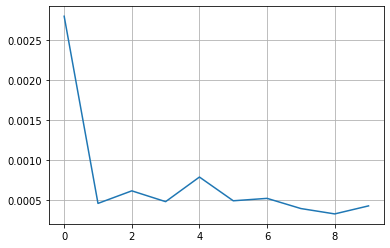

13/13 [==============================] - 0s 1ms/step - loss: 4.4564e-15


,MAE,MSE,MAPE
Train,177028.78495,1.623856e+11,6.402172
Test,813965.40796,2.258331e+12,3.524770


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided
Critical Value(1%),-3.447405e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,1.182942e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Test Statistics,-6.120336e+00,0.096422,7.716026e-01,1.533358e+02,2.008416e+02,2.061470e+02,4.339379e+02,23.8513
Used Lag,1.500000e+01,17.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,3.860000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p-value,8.887012e-08,0.100000,2.902824e-23,3.235051e-35,1.876636e-41,8.416604e-39,1.267785e-62,3.73867e-65


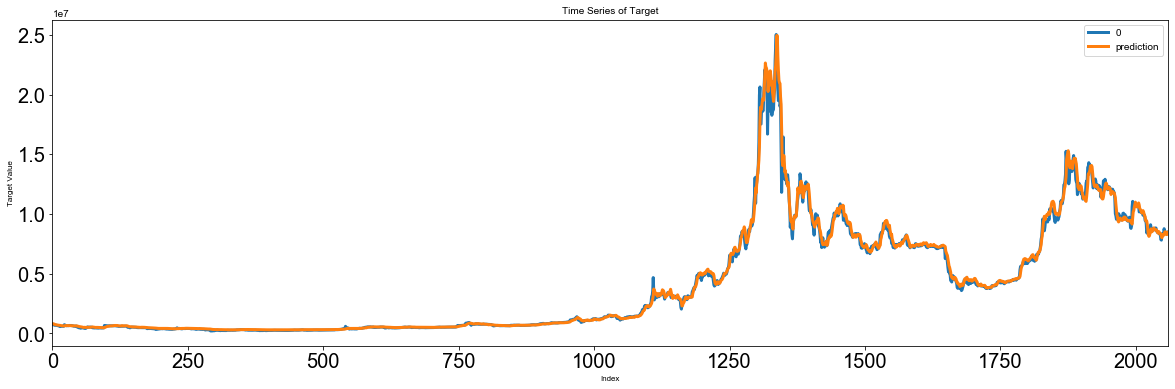

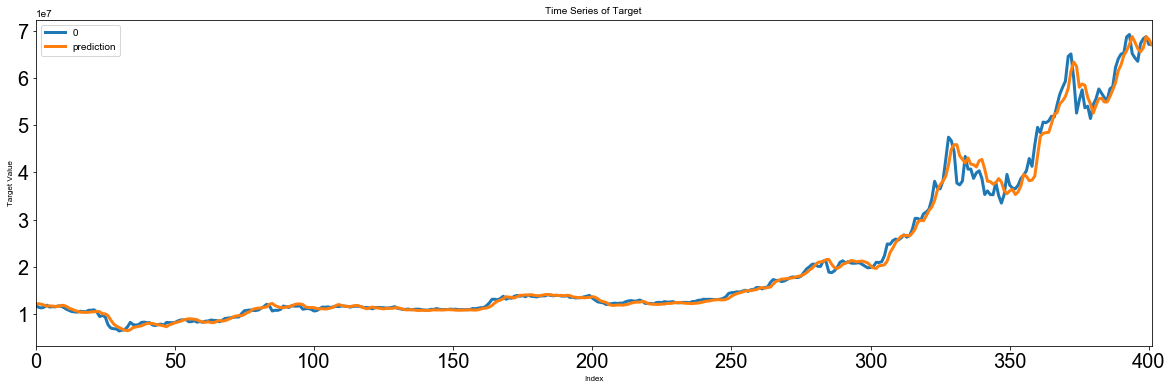

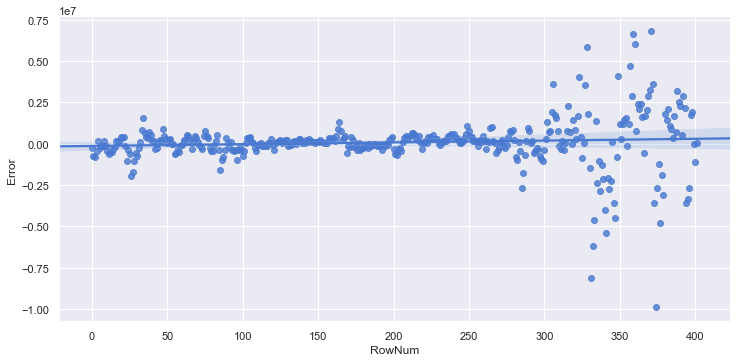

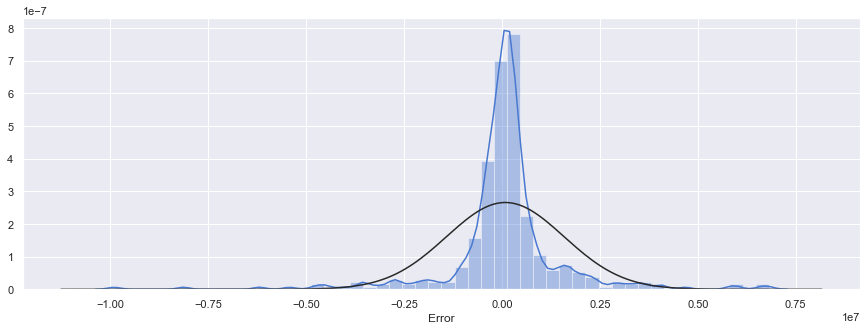

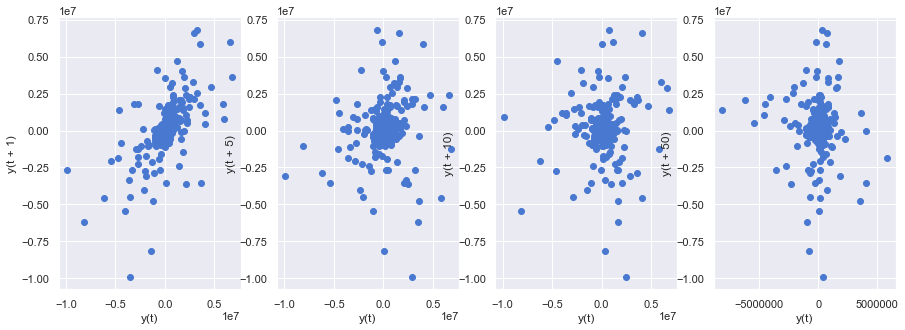

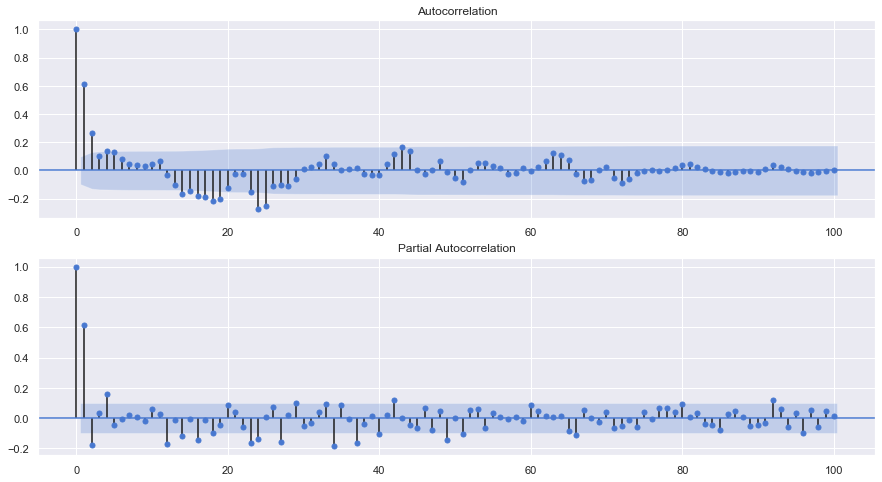

In [5]:
# params
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 45
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# feature engineering
# train & test split
train = df.loc[df.index < criteria,:]
test = df.loc[df.index >= criteria,:]
print('Train_size: ', train.shape, 'Test_size: ', test.shape)

# Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# x / y split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])

X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])
    
# Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('Reshaping for MLP')
print('X_trainL ', X_train.shape, 'Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape, 'Y_test: ', Y_test.shape)
# modelsetting
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)
# loss graph
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
# evaluation
result = model.evaluate(X_test, Y_test_pred)

if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)

# error analysis
error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

### RNN
---
- 시퀀스상 앞선 입력정보를 활용하여 현재 State의 출력을 예측
- 

Train_size: (2106, 1) Test_size: (447, 1)
X_train: (2061, 45, 1) Y_train: (2061, 1)
X_test: (402, 45, 1) Y_test: (402, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 45, 128)           16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 45, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 45, 256)           98560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 45, 256)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 45, 128)           49280     
_________________________________________________________________
dropout_6 (Dropout)          (None, 45, 128)           0        

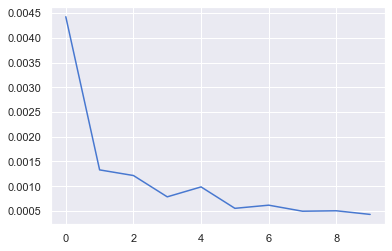

13/13 [==============================] - 1s 13ms/step - loss: 6.0891e-15


,MAE,MSE,MAPE
Train,3.629272e+05,3.494069e+11,18.354991
Test,1.174291e+06,3.265939e+12,6.436116


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided
Critical Value(1%),-3.447495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,11827.380517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Test Statistics,-5.455861,0.340799,7.045724e-01,9.749932e+01,1.429503e+02,1.670391e+02,4.340696e+02,26.231
Used Lag,17.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,384.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p-value,0.000003,0.100000,5.385924e-26,5.387486e-23,4.220940e-29,1.137398e-30,1.195637e-62,3.94186e-68


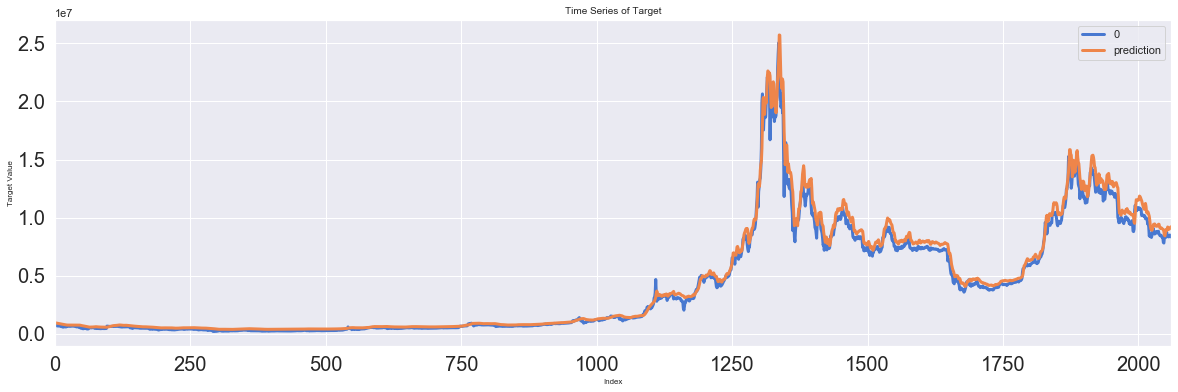

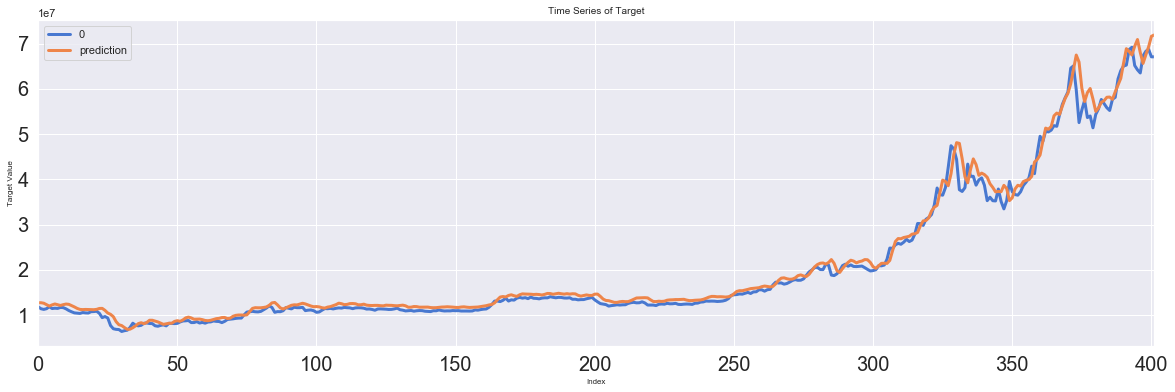

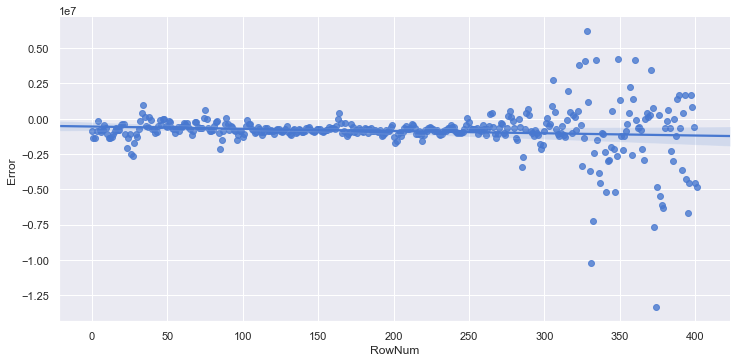

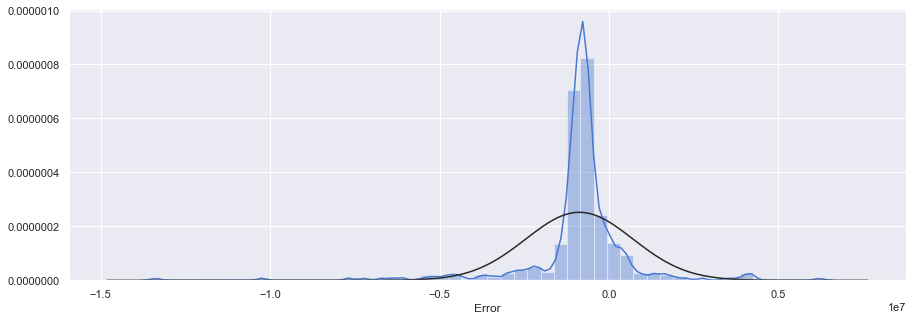

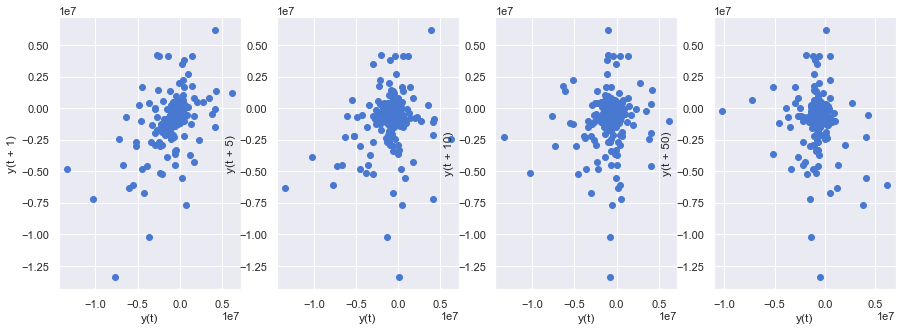

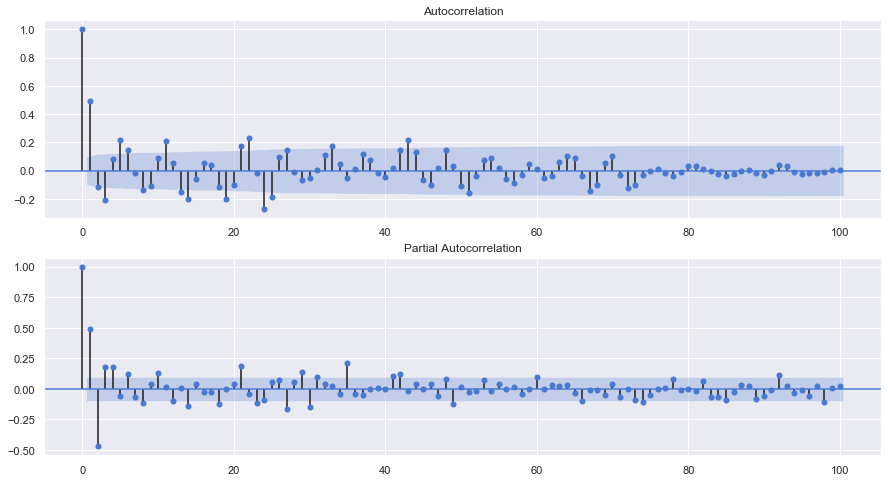

In [6]:
# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 45
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = df.loc[df.index < criteria,:]
test = df.loc[df.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)
# loss graph
plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)

# error analysis
error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

### LSTM
---

Train_size: (2106, 1) Test_size: (447, 1)
X_train: (2061, 45, 1) Y_train: (2061, 1)
X_test: (402, 45, 1) Y_test: (402, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 45, 128)           66560     
_________________________________________________________________
dropout_8 (Dropout)          (None, 45, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 45, 256)           394240    
_________________________________________________________________
dropout_9 (Dropout)          (None, 45, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 45, 128)           197120    
_________________________________________________________________
dropout_10 (Dropout)         (None, 45, 128)           0        

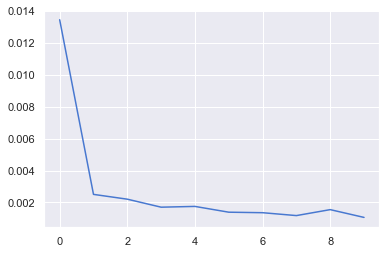

13/13 [==============================] - 1s 64ms/step - loss: 4.2266e-15


,MAE,MSE,MAPE
Train,5.729848e+05,9.559966e+11,26.720724
Test,2.579165e+06,2.260915e+13,11.152054


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided
Critical Value(1%),-3.447229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,11914.984961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Test Statistics,-2.333109,0.487441,6.585469e-01,3.115470e+02,9.113947e+02,1.067173e+03,1.343522e+03,82.2786
Used Lag,11.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,390.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p-value,0.161512,0.044495,1.328625e-27,1.005155e-69,9.098356e-195,6.283535e-223,2.158716e-248,3.6725e-105


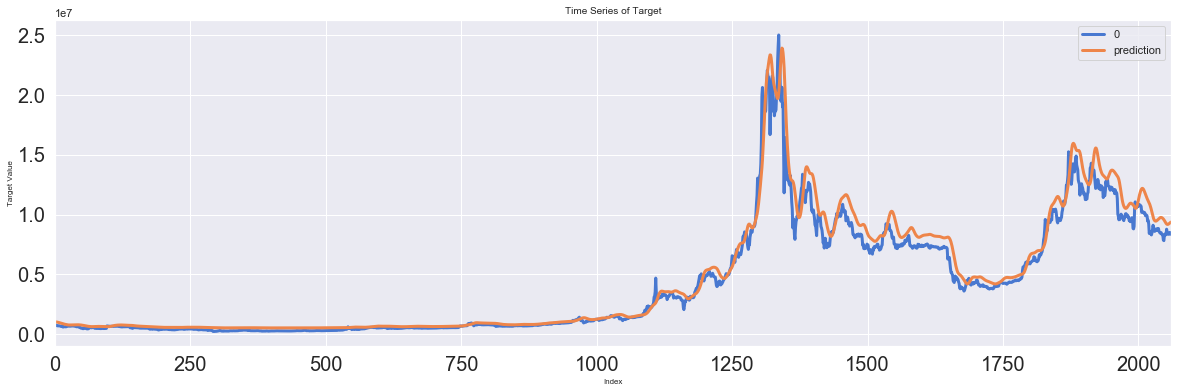

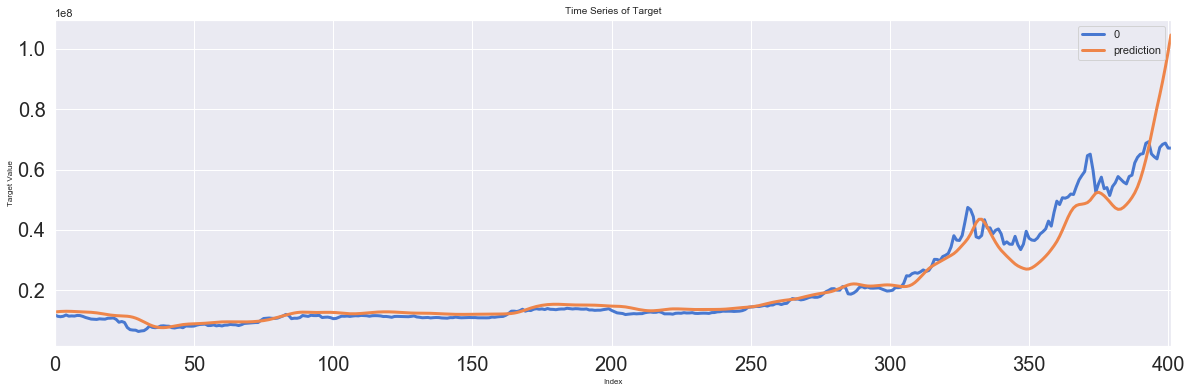

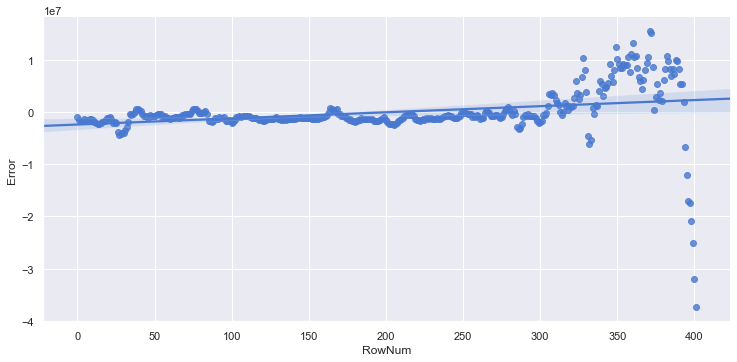

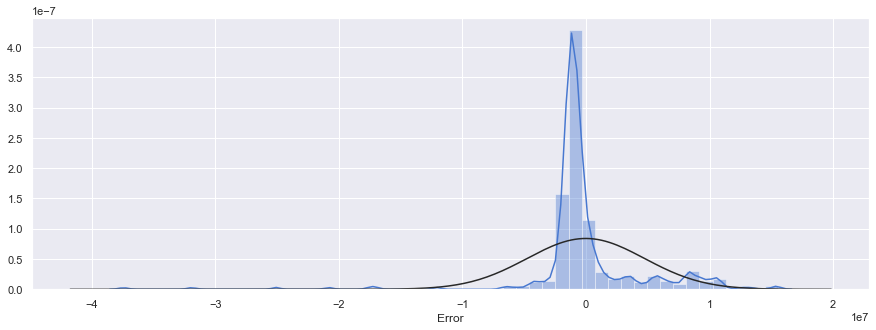

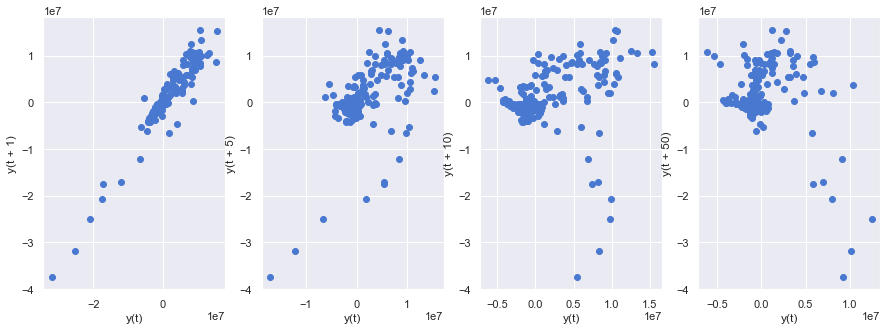

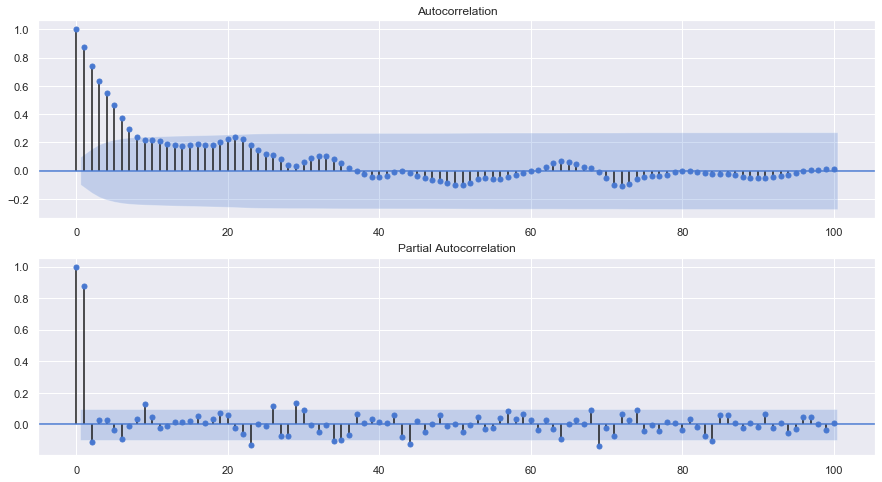

In [7]:
# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 45
batch_size = 60
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = df.loc[df.index < criteria,:]
test = df.loc[df.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

# error analysis
error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

### GRU
---
- internal memory 정보를 저장하지 않음
- LSTM에 있는 input과 forget gate는 GRU의 update gate를 통해 연계되어 표현되며, reset gate는 이전 hidden state와 직접 작용
- GRU는 LSTM에 비해 간단한 구조이지만 비슷한 성능


Train_size: (2106, 1) Test_size: (447, 1)
X_train: (2061, 45, 1) Y_train: (2061, 1)
X_test: (402, 45, 1) Y_test: (402, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 45, 128)           50304     
_________________________________________________________________
dropout_12 (Dropout)         (None, 45, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 45, 256)           296448    
_________________________________________________________________
dropout_13 (Dropout)         (None, 45, 256)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 45, 128)           148224    
_________________________________________________________________
dropout_14 (Dropout)         (None, 45, 128)           0        

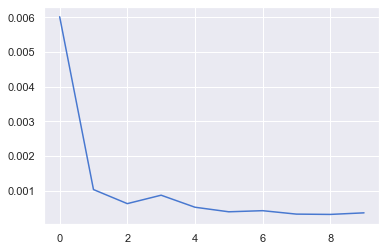

13/13 [==============================] - 1s 35ms/step - loss: 4.7414e-15


,MAE,MSE,MAPE
Train,258320.199873,1.823055e+11,17.725529
Test,685231.888060,1.564218e+12,3.045558


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,two-sided
Critical Value(1%),-3.447186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Critical Value(10%),NaN,0.347000,NaN,NaN,NaN,NaN,NaN,NaN
Maximum Information Criteria,11835.004711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Test Statistics,-3.739389,0.286419,7.510946e-01,4.210070,4.201999e+01,6.017190e+01,2.734184e+02,25.7507
Used Lag,10.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN
Used Observations,391.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p-value,0.003592,0.100000,3.698759e-24,0.040185,5.835795e-08,3.362718e-09,1.504637e-32,1.49917e-67


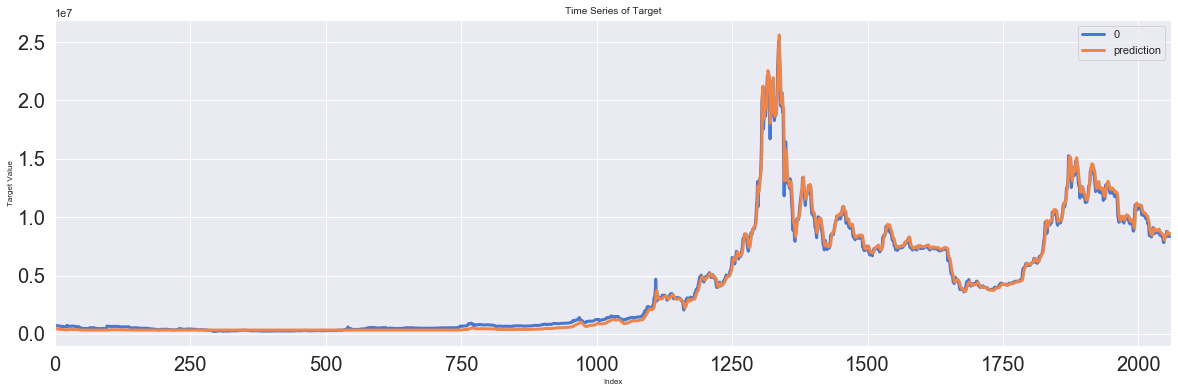

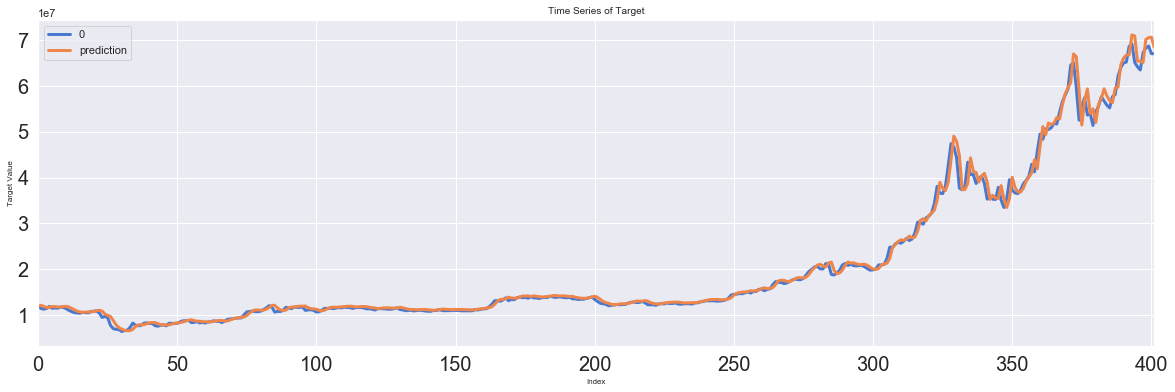

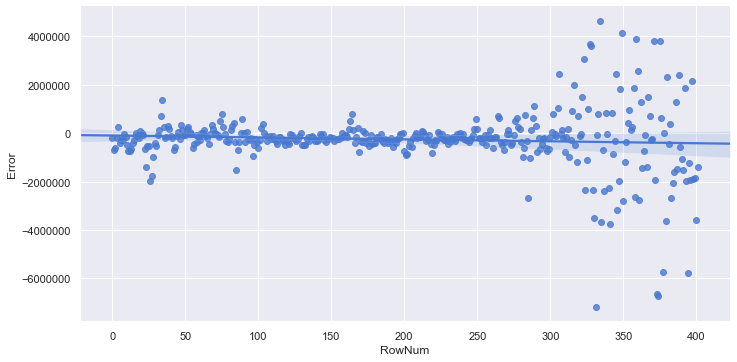

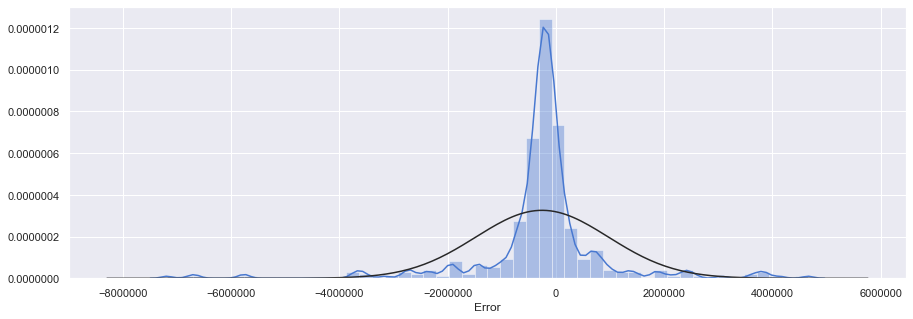

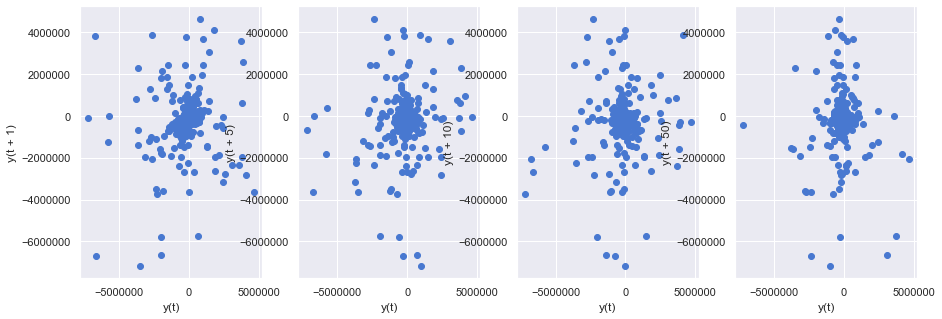

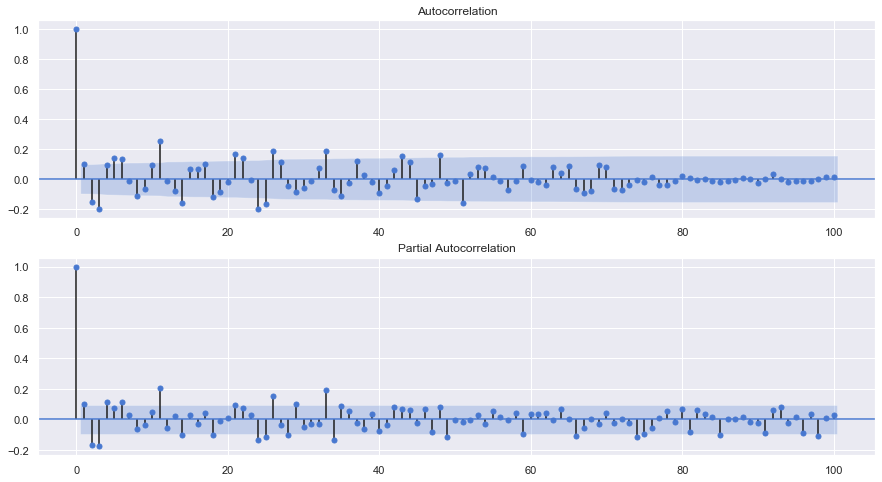

In [8]:
# Parameters
criteria = '2020-01-01'
scaler = preprocessing.MinMaxScaler()
sequence = 45
batch_size = 32
epoch = 10
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = df.loc[df.index < criteria,:]
test = df.loc[df.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)